
# 1-D Static Condensation (Unit 1.4)

Static condensation refers to the process of eliminating unknowns that are internal to elements from the global linear system. They are useful in standard methods and critical in methods like the HDG method. NGSolve automates static condensation across a variety of methods via a classification of degrees of freedom.


In [10]:
import netgen.gui
%gui tk
from ngsolve import *
import ngsolve.internal as ngint
ngint.viewoptions.drawedges = 1
from mesh_util import uniform_1d_mesh
from matplotlib import pyplot as plt
from numpy import linspace

In [2]:
mesh = Mesh(uniform_1d_mesh())
fes = H1(mesh, order=4, dirichlet='right')
u = fes.TrialFunction()
v = fes.TestFunction()

### Asking BilinearForm to condense

In [3]:
a = BilinearForm(fes, eliminate_internal=True)
a += SymbolicBFI(grad(u)*grad(v))
a.Assemble()

f = LinearForm(fes)
f += SymbolicLFI(1*v)
f.Assemble()

u = GridFunction(fes)

The assembled matrix $A=$ a.mat can be block partitioned into
$$A=\left(
\begin{array}{cc}
A_{LL}& A_{LE}\\
A_{EL} & A_{EE}
\end{array}\right)
$$
where $L$ denotes the set of *local or internal* degrees of freedom and $E$ denotes the set of *interface* degrees of freedom.

In our current example $E$ consists of edge and vertex dofs while L consists of triangle dofs. (Note that in practice, $L$ and $E$ may not be ordered contiguously and $L$ need not appear before $E$, but such details are immaterial for our discussion here.)

The condensed system is known as the Schur complement:
$$S=A_{EL}−A_{EL}A_{LL}^{−1} A_{LE}.$$

When eliminate_internal is set to True in $a$, the statement a.Assemble actually assembles $S$

    .

### A factorization
- NGSolve provides
   - a.harmonic_extension_trans =$\left( \begin{smallmatrix} 0 & 0 \\ −A_{EI}A_{LL}^{−1} & 0 \end{smallmatrix} \right)$

   - a.harmonic_extension =$\left( \begin{smallmatrix} 0 & −A_{LL}^{−1}A_{LI} \\ 0 & 0 \end{smallmatrix} \right)$
   
   - a.inner_solve =$\left( \begin{smallmatrix} A_{LL}^{−1} & 0 \\ 0 & 0 \end{smallmatrix} \right).$

- To solve
$$\left(\begin{array}{cc}A_{LL} & A_{LE}\\ A_{EL} & A_{EE}\end{array}\right)\left(\begin{array}{cc}u_L\\u_E\end{array}\right)=\left(\begin{array}{cc}f_L\\f_E\end{array}\right)$$

we use a factorization of $A^{−1}$ that uses $S^{−1}$. Namely, we use the following identity:

$$\left(\begin{array}{c}u_L\\u_E\end{array}\right)=
\left(\begin{array}{cc}I & −A^{−1}_{LL}A_{LE}\\0 & I\end{array}\right)
\left(\begin{array}{cc}A_{LL}^{-1} & 0\\ 0 & S^{-1} \end{array}\right)
\underbrace{\left(\begin{array}{cc}I & 0\\-A_{EL}A_{LL}^{-1}& I \end{array}\right)
\left(\begin{array}{c}f_L\\f_E\end{array}\right)}_{\left(\begin{smallmatrix}f'_L\\f'_E\end{smallmatrix}\right)}$$

We implement this formula step by step, starting with the computation of $f'_L$ and $f'_E$.
### Steps to compute the solution

- The following step implements
$$\left(\begin{array}{c}f'_L\\f'_E\end{array}\right) =
\left(\begin{array}{cc}I & 0\\-A_{EL}A_{LL}^{-1}& I \end{array}\right)
\left(\begin{array}{c}f_L\\f_E\end{array}\right)$$

In [4]:
f.vec.data += a.harmonic_extension_trans * f.vec

- The next step implements part of the next matrix application in the formula. 
$$\left(\begin{array}{c}0\\u_E\end{array}\right) =
\left(\begin{array}{cc}0 & 0\\0 & S^{-1} \end{array}\right)
\left(\begin{array}{c}f'_L\\f'_E\end{array}\right)$$

In [5]:
u.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs(coupling=True))*f.vec

- Note:

   - Because we set eliminate_internal in a, the inverse a.mat.Inverse actually computes $S^{−1}$

   - Note that instead of the usual fes.FreeDofs(), we have used fes.FreeDofs(coupling=True) or simply fes.FreeDofs(True) to specify that only the degrees of freedom that are *not local* and *not Dirichlet* should participate in the inverse computations. (The underlying assumption is that Dirichlet dofs cannot be local dofs.)

   - Next, we compute
   
$$\left(\begin{array}{c}u'_L\\u_E\end{array}\right) =
\left(\begin{array}{c}0\\u_E\end{array}\right) +
\left(\begin{array}{cc}A_{LL}& 0\\0 & 0 \end{array}\right)
\left(\begin{array}{c}f'_L\\f'_E\end{array}\right).$$


In [6]:
u.vec.data += a.inner_solve * f.vec

Finally: 
$$\left(\begin{array}{c}u_L\\u_E\end{array}\right) =
\left(\begin{array}{cc}I & -A_{LL}^{-1}A_{LE}\\0 & I \end{array}\right)
\left(\begin{array}{c}u'_L\\u_E\end{array}\right)$$

In [7]:
u.vec.data += a.harmonic_extension * u.vec

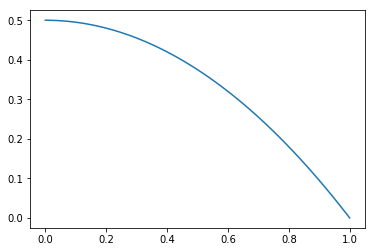

In [11]:
Draw(u)
xs = linspace(0,1,100)
plt.plot(xs, [u(x) for x in xs])


### Behind the scenes: CouplingType

How does NGSolve know what is in the index sets $L$ and $E$?

- Look at fes.CouplingType to see a classification of degrees of freedom.


In [12]:
for i in range(fes.ndof):
    print(fes.CouplingType(i))

COUPLING_TYPE.WIREBASKET_DOF
COUPLING_TYPE.WIREBASKET_DOF
COUPLING_TYPE.WIREBASKET_DOF
COUPLING_TYPE.WIREBASKET_DOF
COUPLING_TYPE.WIREBASKET_DOF
COUPLING_TYPE.WIREBASKET_DOF
COUPLING_TYPE.WIREBASKET_DOF
COUPLING_TYPE.WIREBASKET_DOF
COUPLING_TYPE.WIREBASKET_DOF
COUPLING_TYPE.WIREBASKET_DOF
COUPLING_TYPE.WIREBASKET_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_TYPE.LOCAL_DOF
COUPLING_

In [13]:
doftypes = {}
for i in range(fes.ndof):
    type = fes.CouplingType(i)
    if type in doftypes.keys():
        doftypes[type] += 1
    else:
        doftypes[type] = 1
doftypes

{COUPLING_TYPE.WIREBASKET_DOF: 11, COUPLING_TYPE.LOCAL_DOF: 30}

The LOCAL_DOF forms the set $L$ and the remainder forms the set $E$. All finite element spaces in NGSolve have such dof classification.

Through this classification a bilinear form is able to automatically compute the Schur complement and the accompanying extension operators. Users need only specify the flag eliminate_internal. (Of course users should also make sure their method has an invertible $A_LL$!)
### Inhomogeneous Dirichlet boundary conditions

In case of inhomogeneous Dirichlet boundary conditions we must combine the technique of Dirichlet data extension in a previous tutorial with static condensation:


In [14]:
U = x*x        # U = manufactured solution
DeltaU = CoefficientFunction(2) # Source: DeltaU = ∆U

f = LinearForm(fes)
f += SymbolicLFI(-DeltaU*v)
f.Assemble()

u = GridFunction(fes)
u.Set(U, BND)               # Dirichlet b.c: u = U

# Modify source per Dirichlet extension technique:
r = f.vec.CreateVector()
r.data = f.vec - a.mat * u.vec
r.data += a.harmonic_extension_trans * r

# Apply the static condensation technique:
u.vec.data += a.mat.Inverse(fes.FreeDofs(True)) * r
u.vec.data += a.harmonic_extension * u.vec
u.vec.data += a.inner_solve * r

sqrt(Integrate((U-u)*(U-u),mesh))  # Compute error


3.0716043106192853e-16